# End-to-End multi-class dog-breed classification

This notebook buillds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

I want to know the breed of a dog from an image of it.

## 2. Data

The data is from kaggle's dog breed identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

Evaluation on Multi Class Log Loss between the predicted probability and the observed target. predict a probability for each of the different breeds.
https://www.kaggle.com/competitions/dog-breed-identification

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best to use Deep learning.
* There are around 120 breeds of dogs.
* There are around 10,000+ images in the training set(these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll have to predict them).

### Get our workspace Ready

* Import TensorFlow 2.x.
* Import TensorFlow Hub.
* Make sure you are using a GPU.

In [5]:
# Import the necessary tools

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:",tf.__version__)
print("TF Hub version:",hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.19.0
TF Hub version: 0.16.1
GPU available


## Getting the data ready

Get the data into tensors(matrix).
With all ML models our data must be in numerical format.

Access our data and check out the labels


In [6]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/dog_img/dog-breed-identification/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

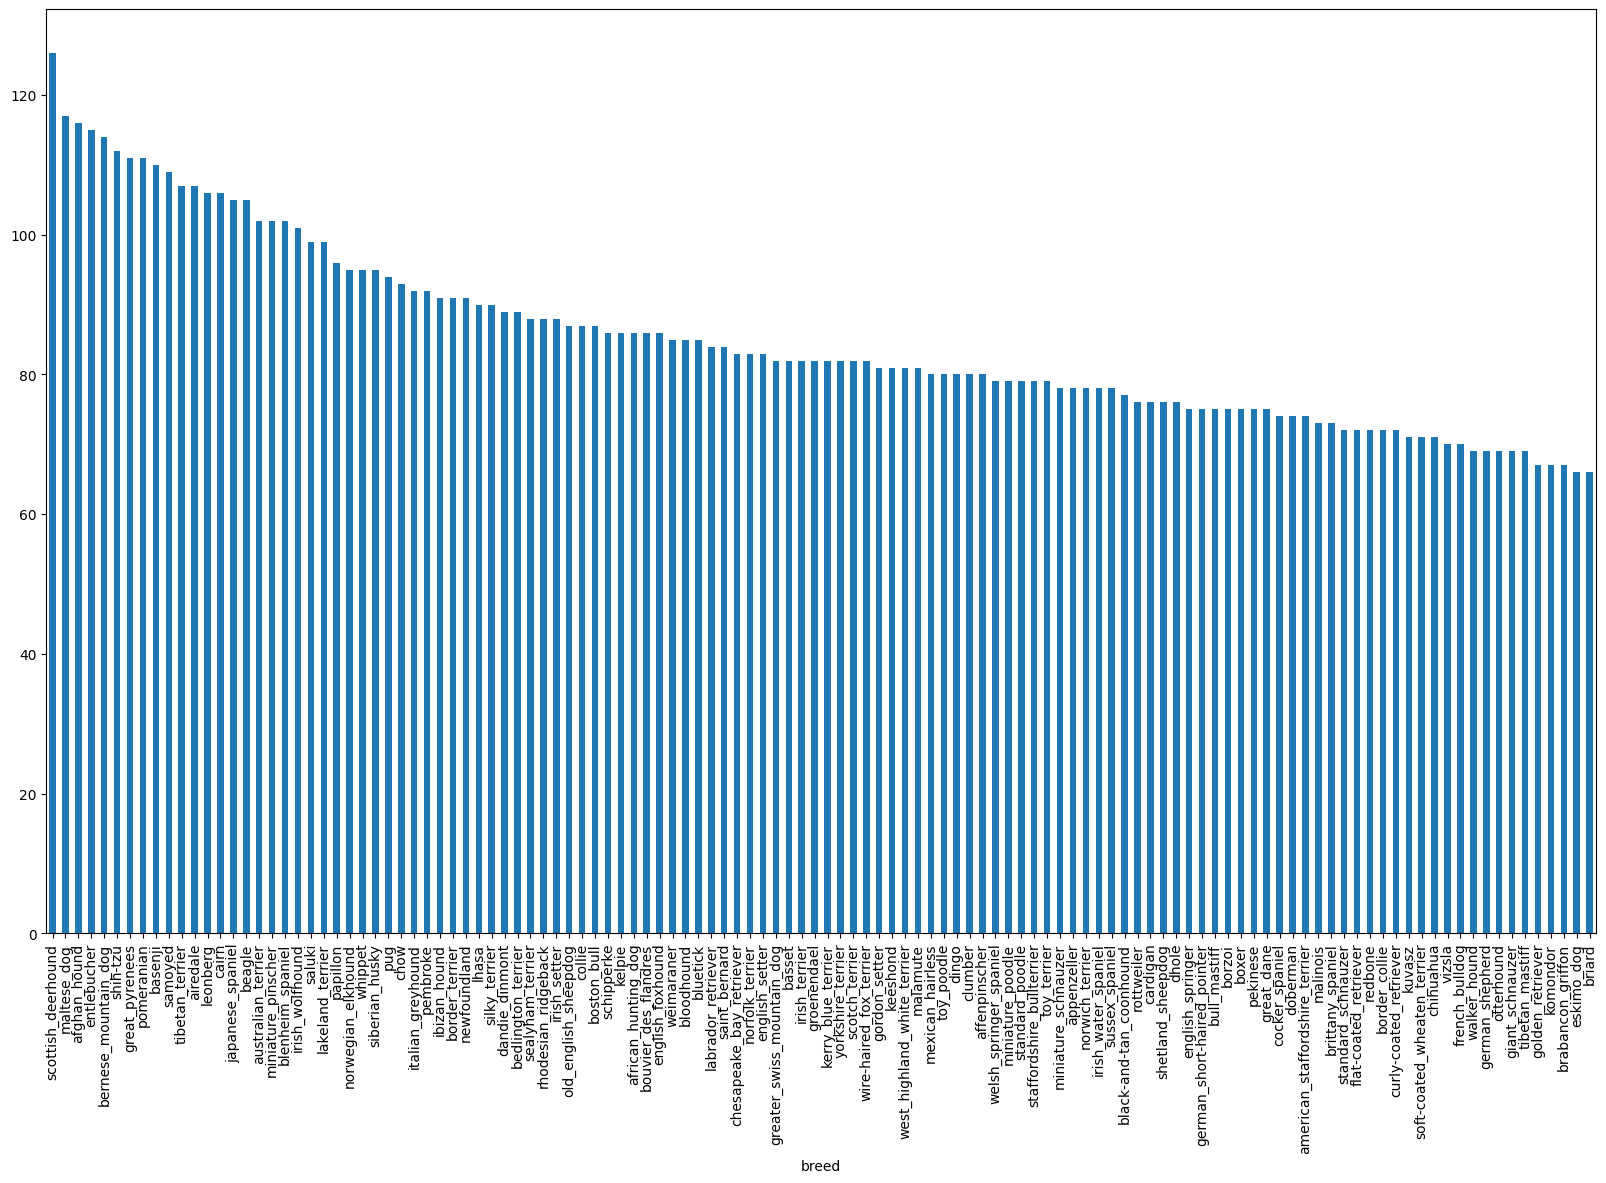

In [7]:
# How many images our there of each breed
labels_csv['breed'].value_counts().plot.bar(figsize=(20,12))

In [8]:
labels_csv['breed'].value_counts().median()

82.0

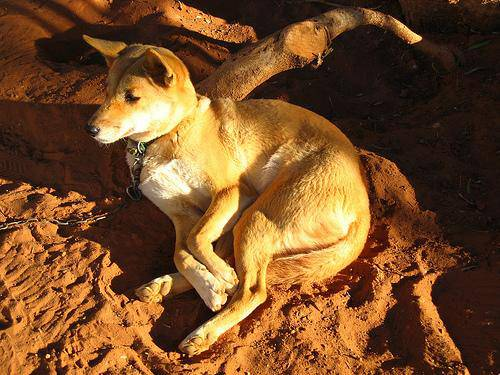

In [9]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/dog_img/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels
Let's get a list all of our image file name

In [10]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
# Create pathnames from images ID's
filenames = ["drive/MyDrive/dog_img/dog-breed-identification/train/"+fname+".jpg" for fname in labels_csv['id']]
filenames[:10]

['drive/MyDrive/dog_img/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
# Check weather number of filenames number of actual image files
import os
if len(os.listdir("drive/MyDrive/dog_img/dog-breed-identification/train")) == len(filenames):
  print("length of filenames match.")
else:
  print("length of filenames does not match.")

length of filenames match.


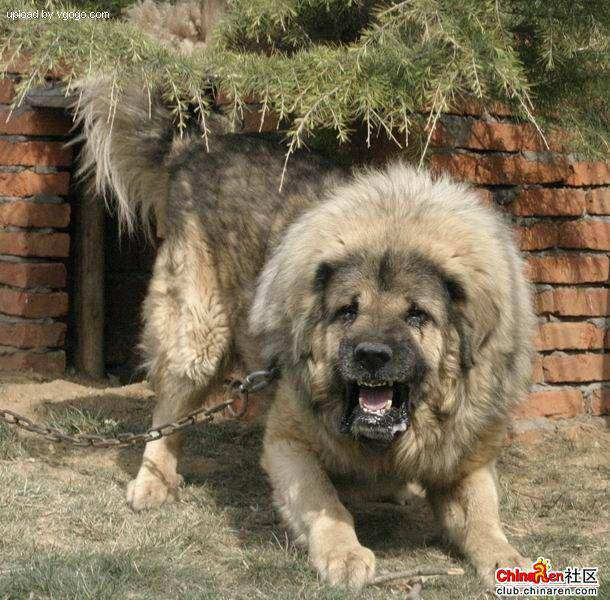

In [13]:
# One more check
Image(filenames[9000])

In [14]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since We've now got our training imag filepaths in a list, let's prepare our labels

In [15]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
# labels= np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [16]:
len(labels)

10222

In [17]:
# See if num of labels matches  number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches filenames amount")
else:
  print("lumber of labels does not match filenames")

Number of labels matches filenames amount


In [18]:
# Find unique label values
unique_breeds= np.unique(labels)
len(unique_breeds)

120

In [19]:
print(unique_breeds)

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfhound'
 'italian

In [20]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [21]:
# Turn every labels into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [22]:
len(boolean_labels)

10222

In [23]:
len(labels)

10222

In [24]:
# Example: Turning boolean array into intergers
print(labels[0])# original label
print(np.where(unique_breeds == labels[0]))# index where label occurs
print(boolean_labels[0].argmax())# index where label occurs in booleean array
print(boolean_labels[0].astype(int))# there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from kaggle does'nt have a validation set we are making our own.

In [25]:
# Setup X and y variables
X=filenames
y=boolean_labels

We're going to start of with 1000 images and increase as needed

In [26]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 # @param {"type":"slider","min":1000,"max":10000,"step":1000}

In [27]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Splitting them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [28]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/dog_img/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/dog_img/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/dog_img/dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/dog_img/dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/dog_img/dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, Fals

## Preprocessing images (turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things(same for every type of data)
1. Take an image filepath
2. Use TensorFlow to read the file and save it to a varriable, 'image'
3. Turn our 'image' (a jpg) into Tensors
4. Resize the 'image' to be a shape of(224,224)
5. Return the modified image

https://www.tensorflow.org/tutorials/load_data/images

In [29]:
# Convert an image to a numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [30]:
image.min(), image.max()

(np.uint8(0), np.uint8(255))

In [31]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [32]:
# Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now We've seen what an image looks like as a Tensor, let's make a function to preprocess them
1. Take an image filepath
2. Use TensorFlow to read the file and save it to a varriable, 'image'
3. Turn our 'image' (a jpeg) into Tensors
4. Normalize the image convert from 0-255 to 0-1
5. Resize the 'image' to be a shape of(224,224)
6. Return the modified image

In [33]:
# Define image size
IMG_size = 224

# Create a preprocessing function for the images
def process_image(image_path, image_size=IMG_size):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numeric tensor with 3 color channels (R,G,B)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channels values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_size, IMG_size])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go.. they all might not fit into memory.

That's why we do 32 images at a time( this is the batch size).

In order to use the TensorFlow effectively, we need our data in the form of a Tensor tuples which look like this:
'(image, label)'.

In [34]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file name and the assosiated label, processes the image and
  returns the image as a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label


In [35]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn out data into tuples of Tensors in the form of: '(image, label)', let's make a function to turn all of out data (X, y) into batches!

In [36]:
# Define the batch size, 32  is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of image (X) and label(y) pairs.
  Shuffles the data if it's training data but does'nt shuffle if it's validation data.
  Also Accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have the labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no_labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),# filepaths
                                               tf.constant(y)))# labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling after
    data = data.shuffle(buffer_size=len(X))

    # Create tuples (this also turn the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [37]:
# Creating and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [38]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data batches
Our data is in batches now however these can be very difficult to understand so lets visulize them

In [39]:
import matplotlib.pyplot as plt
# Create a function for viewing images in the data batches
def show_25_iamges(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))

  # Loop through 25 for displayin 25 images
  for i in range(25):
    # Create subplot (5 rows, 5cols)
    ax=plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

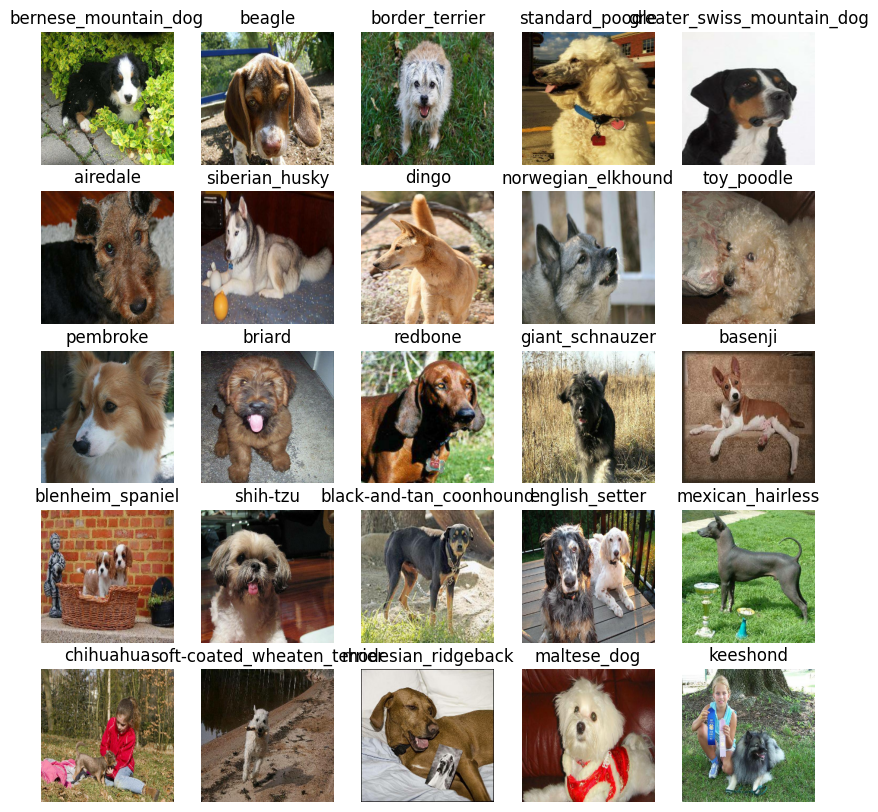

In [40]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_iamges(train_images, train_labels)

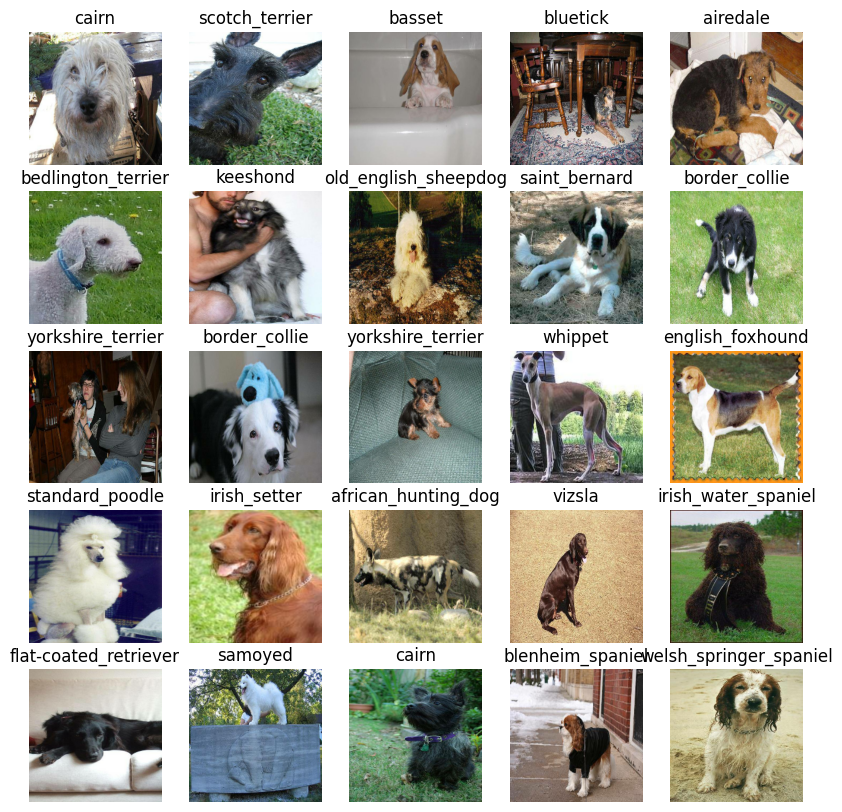

In [41]:
# Now let's visualize the data in a validation batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_iamges(val_images, val_labels)

## This is called building a model

Before we build a model, there are a few things we need to define
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape(image labels, in the form of Tensor) of our model.
* The URL of the model we want to use.
From TennsorFLow hub/Kaggle: https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/1?tfhub-redirect=true


In [42]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_size, IMG_size, 3] # batch, height, width, color channels

# Setup shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub (using a MobileNetV2 feature vector model)
MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

Now we've got our inputs outputs and model ready to go.
Let's put them together into a keras deep learning model.

Knowing this, Let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Define the layers ina Keras model in sequestial fashion (do this first, then this, then that).
* Compiles the model( says how it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model.

In [43]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras  # Use this explicitly for model building

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    # Use keras.Sequential from tf_keras, NOT tf.keras
    model = keras.Sequential([
        hub.KerasLayer(model_url),# Layer 1 (input layer)
        keras.layers.Dense(units=output_shape, activation="softmax")# Layer 2(output layer)
    ])

    model.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    model.build(input_shape)
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


### Creating callbacks

Callbacks our helper functions a model can use during training to do such things as save it's progress, check it's progress or stop training early if a model stops improving.

We'll create 2 callbacks, one for tensorboard which helps track our models progress and another for early stoping which prevents our model from overfitting.

### TensorBoard Callback

To setup a TensorBoard callback we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.
3. Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).

In [44]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [45]:
import datetime

# Create a function to build a TensorBoard callback
def Create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/dog_img/dog-breed-identification/logs",
                        # Make it so that the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return keras.callbacks.TensorBoard(logdir)

### Early stopping callback

Early stopping helps stop our model from oberfitting by stopping training the model if a certain evaluation metric stops improving.


In [46]:
# Create early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=3)

## Training a model (on a subset of data)

Our first model is only going to train on 1000 images to make sure everything is working.

In [47]:
NUM_EPOCHS = 100 # @param {"type":"slider","min":10,"max":100,"step":10}

In [48]:
# Check to make sure we are still running on a GPU
print("GPU","Available." if tf.config.list_physical_devices("GPU") else "Not available.")

GPU Available.


Let's create a function which trains a model.

* Create a model using 'create_model()'.
* Setup a TensorBoard callback using 'create_tensorboard_callback()'.
* Call the fit() function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use.
* Return the model.

In [49]:
# Build a function to train and return a trained model
def train_model():
  """
  Train a given model and return the trained version.
  """

  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = Create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(
      x=train_data,
      epochs=NUM_EPOCHS,
      validation_data=val_data,
      validation_freq=1,
      callbacks=[tensorboard, early_stopping]
  )

  # Return the fitted model
  return model

In [50]:
# Fit the model to the data
model = train_model()


Epoch 1/100


KeyboardInterrupt: 

Looks like our model is overfitting as it is performing way beteer on training dataset than validation set

**Note:** Overfitting to begin with is a good thing it mean our model is learning.

### Checking the TensorBoard logs

The TensorBoard magic function ('%tensorboard') will access the logs directory we created and cisualize it's content

In [51]:
%tensorboard --logdir drive/MyDrive/dog_img/dog-breed-identification/logs

Launching TensorBoard...

KeyboardInterrupt: 

## Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

In [ ]:
predictions.shape

In [ ]:
# First prediction
index=42
print(predictions[index])
print(f"Max value (probability of preditcions): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted breed: {unique_breeds[np.argmax(predictions[index])]}")

In [ ]:
unique_breeds[113]

Having the above functionality is great but we want it to be able to fo it over scale.

And it would be even better if we could see the image the prediction is being mad on!.

**Note:** Prediction probabilities are also known as confidence levels.

In [53]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of predictions into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Check
# pred_label = get_pred_label(predictions[81])
# pred_label

Now since Our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those pedictions to the validate labels (truth labels).

In [54]:
# Create a function to unbatch a bacth dataset
def unbatch(dataset):
  """
  Takes a batched dataset of (image, label) Tensors and return seperate arrays
  of images and labels.
  """
  images_ = []
  labels_ = []

  # Loop through unbatched data
  for image, label in dataset.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(unique_breeds[np.argmax(label)])

  return images_, labels_

# Check
# val_images, val_labels = unbatch(val_data)
# val_images[0], val_labels[0]

Now we've got way to get prediction labels and validation labels and val images let's make some functions to make all this visual.

We'll create a function which takes an array of prediction probabilities, an array of truth label and an array of image and integer.

Convert the prediction probabilities to a predicted label.

Plot the predicted label, it's predicted probability, the truth label and the target image on a single plot.

In [55]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color="green"
  else:
    color="red"

  # change plot title to be predicted, probability of predictions and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=99)

Now we've got one function to visualize our models predictions let's make another to view our models top 10 predcitions.

* Take an input of predictions of probabilities array and a ground truth array and an integer.
* Find the prediction using 'get_pred_label()'.
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probabilities values and labels, coloring the true label green

In [56]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest predictions confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted labels
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation="vertical")

  # Change color of the true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,labels=val_labels,n=99)

Now we've got some functions to visualize our predictions and evaluate our model, let's check out a few

In [ ]:
#  Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
  plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

In [57]:
# greate a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/dog_img/dog-breed-identification/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}....")
  model.save(model_path)
  return model_path

In [58]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from our specified path.
  """

  print(f"Loading saved model from: {model_path}")
  model = keras.models.load_model(model_path,
                                 custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model("/content/drive/MyDrive/dog_img/dog-breed-identification/models/20260103-07001767423649-1000-images-mobilenetv2-Adam.h5")

In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

## Training the model on the full data

In [ ]:
len(X), len(y)

In [ ]:
len(X_train)

In [ ]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)

In [ ]:
full_data

In [ ]:
# Create a model for full_model
full_model = create_model()

In [ ]:
# Create full_model callbacks
full_model_tensorboard = Create_tensorboard_callback()

# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = keras.callbacks.EarlyStopping(monitor="accuracy",
                                                          patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minutes for the first epoch) because the GPU we're using the runtime has to load all the images into memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,full_model_early_stopping])

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="full-images-mobilenetv2-Adam")

In [59]:
full_model = load_model("/content/drive/MyDrive/dog_img/dog-breed-identification/models/20260103-07401767426016-full-images-mobilenetv2-Adam.h5")

Loading saved model from: /content/drive/MyDrive/dog_img/dog-breed-identification/models/20260103-07401767426016-full-images-mobilenetv2-Adam.h5


## Making predictions on the test data set

We need to covert the test data into the same format as the train dataset that is tensors.

Luckily we created create data batches which can take a list of filenames as input and convert them into Tensor batches.

* Get the test data filenames
* Convert the filenames into test data batches using 'create_data_batches' and setting the 'test_data' parameter to 'True' (since the test data doesn't have labels).
* Make a prediction array by passing the test batches to the 'predict()' method called on our model.

In [60]:
# Load test image file names
test_path = "drive/MyDrive/dog_img/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/dog_img/dog-breed-identification/test/e610bd621c660546f7cd1cd6554a5caf.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/test/e50319e7efc447bb684fbfdbed3ff041.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/test/e7be7b911a4cba9fdfa4105ec4776370.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/test/e78b50f1d12148deef4c564ea4c88050.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/test/e7f95aabf775a636b3893ffa120adaf9.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/test/e806a67a05289ac6de6831001664b81b.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/test/e64d56f012476f124591a22648114a37.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/test/e5c313a35ac162b3b88b50157f6fd309.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/test/e8e68264f76c3398ecb6c67b9bb52833.jpg',
 'drive/MyDrive/dog_img/dog-breed-identification/test/e587c21aedc81f89b83dd326e034e7e0.jpg']

In [61]:
len(test_filenames)

10358

In [62]:
# Create test data batch
test_data = create_data_batches(test_filenames,test_data=True)

Creating test data batches...


In [63]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** calling predict on the full model andd passing it to the test data batch will take long time to run.

In [65]:
# Make predictions on test data batch using the loaded full model
test_predictions = full_model.predict(test_data,
                                      verbose=1)

324/324 [==============================] - 44s 135ms/step


In [66]:
# save prediction (Numpy array) to csv file (for access later)
np.savetxt("/content/drive/MyDrive/dog_img/dog-breed-identification/predict_arrays.csv", test_predictions, delimiter=",")

In [68]:
# Load predictions from csv file
test_predictions = np.loadtxt("/content/drive/MyDrive/dog_img/dog-breed-identification/predict_arrays.csv",delimiter=",")


In [69]:
test_predictions.shape

(10358, 120)

### preparing test dataset predictions for kaggle

* Crete a dataframe and convert it to csv

In [70]:
# Create a pandas datafframe with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [74]:
# Append test image 'Ids' to predictions dataframe
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

preds_df['id'] = test_ids

In [75]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e610bd621c660546f7cd1cd6554a5caf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e50319e7efc447bb684fbfdbed3ff041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e7be7b911a4cba9fdfa4105ec4776370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e78b50f1d12148deef4c564ea4c88050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e7f95aabf775a636b3893ffa120adaf9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e610bd621c660546f7cd1cd6554a5caf,1.411140e-06,0.000059,8.663773e-06,1.381539e-05,2.164689e-05,1.692576e-04,2.407621e-05,1.385584e-05,6.486246e-05,...,2.279561e-05,1.786412e-06,1.455464e-02,7.078047e-04,0.001526,5.004001e-05,7.209565e-06,0.000301,0.000344,8.180882e-06
1,e50319e7efc447bb684fbfdbed3ff041,1.742507e-04,0.000017,6.996896e-05,8.880455e-04,4.434056e-04,1.738259e-01,5.275665e-05,7.465117e-04,3.553849e-04,...,6.150742e-05,1.437288e-04,1.533629e-04,1.185886e-04,0.000174,4.393262e-04,3.990561e-05,0.000032,0.000226,1.672315e-04
2,e7be7b911a4cba9fdfa4105ec4776370,2.137558e-03,0.001515,6.103630e-04,3.216878e-04,3.534587e-04,4.284675e-05,9.486374e-04,3.881729e-04,3.706673e-04,...,6.515193e-05,1.484534e-04,9.834749e-05,1.550465e-04,0.000065,1.905135e-05,1.307045e-03,0.000149,0.000335,7.231741e-04
3,e78b50f1d12148deef4c564ea4c88050,1.381763e-07,0.000008,8.657913e-07,2.828253e-07,5.482395e-08,7.583555e-08,1.129836e-07,7.359857e-08,1.446066e-08,...,2.376900e-08,2.498307e-08,4.940616e-07,8.686628e-07,0.000002,1.208502e-07,2.169144e-07,0.000005,0.000012,1.834163e-07
4,e7f95aabf775a636b3893ffa120adaf9,3.176365e-01,0.000091,4.887806e-05,4.122360e-05,1.164844e-03,3.194631e-05,4.215658e-04,3.438521e-04,1.573014e-05,...,5.242310e-03,1.115231e-04,6.977056e-05,1.537049e-04,0.000135,9.571447e-05,1.896991e-04,0.000054,0.000005,1.248800e-03


In [77]:
# Convert to csv and save
preds_df.to_csv("/content/drive/MyDrive/dog_img/dog-breed-identification/submission_predictions.csv", index=False)